In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import os
import glob
import seaborn as sns
import scipy
import scipy.stats as stats
from adjustText import adjust_text
import pyproj
from osgeo import gdal, osr, ogr

import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter, LatitudeLocator)

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from lib.funcs import *
from lib.schron2017 import *
from lib.crnsFit import *

# save_figs_to = '/Users/hkim139/Documents/research/01.presentations/ESC2024/figs/'


Points List:
- p00: (,): Original CARC location (2020/21)
- p01: (   0,    0) : Center
- p02: (-280,  280)
- p03: (   0,  280)
- p04: ( 280,  280)
- p05: (-280,    0)
- p06: ( 280,    0)
- p07: (-280, -280)
- p08: (   0, -280)
- p09: ( 280, -280)

New Points:
- p10 (-140,  280)
- p11 ( 140,  280)
- p12 (-280,  140)
- p13 (-140,  140)
- p14 (   0,  140)
- p15 ( 140,  140)
- p16 ( 280,  140)
- p17 (-140,    0)
- p18 ( 140,    0)
- p19 (-280, -140)
- p20 (-140, -140)
- p21 (   0, -140)
- p22 ( 140, -140)
- p23 ( 280, -140)
- p24 (-140, -280)
- p25 ( 140, -280)

In [2]:
# get filenames of lidar SD files
fnames_old = glob.glob('/Users/hkim139/mntpoint/General/Montana/hkim/LIDAR/lidar_maps/*.txt')
fnames = glob.glob('/Users/hkim139/mntpoint/General/Montana/LIDAR_2021/R_Files/Gapfilled_lidar_for_modeling/*.txt')

fnames_0115 = fnames_old[0]

In [3]:
sd_0115 = np.loadtxt(fnames_0115, delimiter=',')
sd_0121 = np.loadtxt(fnames[0], delimiter=',')
sd_0122 = np.loadtxt(fnames[1], delimiter=',')
sd_0129 = np.loadtxt(fnames[2], delimiter=',')
sd_0217 = np.loadtxt(fnames[3], delimiter=',')
sd_0218 = np.loadtxt(fnames[4], delimiter=',')
sd_0224 = np.loadtxt(fnames[5], delimiter=',')
sd_0304 = np.loadtxt(fnames[6], delimiter=',')

In [4]:
def plotPointFpt(ax, p, c, ls, s='', label=''):
    xx = (p[0] + 500)/2
    yy = np.abs(p[1] - 500)/2
    ax.plot(xx, yy, ls, label=label)
    circ = plt.Circle((xx, yy), 100, facecolor='none',
                      edgecolor=c, ls='--')
    ax.add_patch(circ)
    ax.text(xx, yy, s, color='k')
    
    
def plotPoint(ax, p, c, ls, s=''):
    xx = (p[0] + 500)/2
    yy = np.abs(p[1] - 500)/2
    ax.plot(xx, yy, ls)
    ax.text(xx, yy, s, color='k')

def mask_0_sd(dsm):
    dsm_BareMask = np.ma.masked_where(dsm == 0.0, dsm)
    np.ma.set_fill_value(dsm_BareMask, np.nan)
    return(dsm_BareMask)

In [5]:
# 500 by 500 grid boundaries
xmn=579026.5
xmx=580026.5
ymn=5211964
ymx=5212964

# Convert Lat/Lons to DTM
DTM = pyproj.Proj("+proj=utm +zone=12 +datum=NAD83 +units=m +no_defs")
CRNS = pyproj.Proj("+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0")
CRNSlon, CRNSlat = -109.955567, 47.059422
UTMx, UTMy = DTM(CRNSlon, CRNSlat)
print(UTMx, UTMy)

# Convert UTM to Lat/Lon
minlon, minlat = DTM(xmn, ymn, inverse=True)
maxlon, maxlat = DTM(xmx, ymx, inverse=True)

# Find x,y location for CRNS in mm (0,0) is center
u_x, u_y = (UTMx-xmn) - 500, UTMy-ymn - 500
u_x*1000, u_y*1000

m_x, m_y = (UTMx-xmn)/2, (ymx-UTMy)/2

579315.2340704725 5212296.738658515


In [6]:
from matplotlib_scalebar.scalebar import ScaleBar

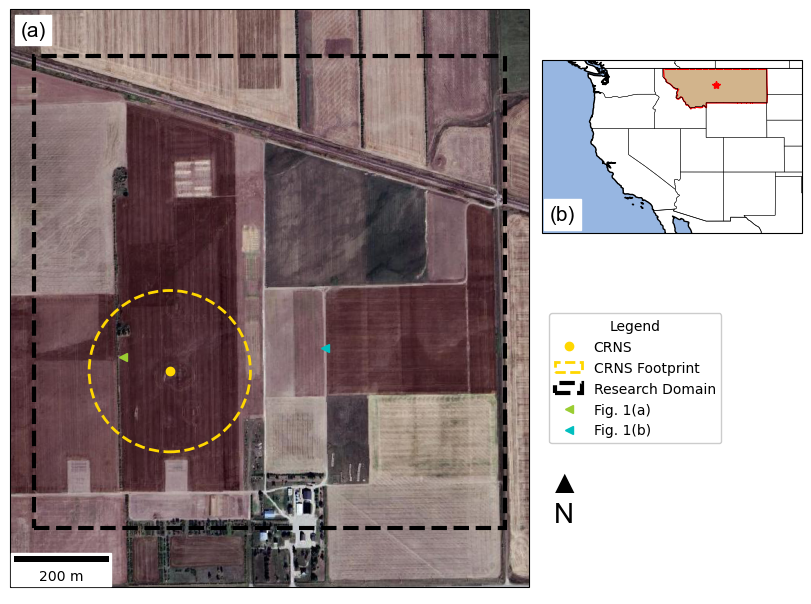

In [28]:
#- Figure 2 Code -----------------
fig = plt.figure(figsize=(8,6), constrained_layout=True)
gs = fig.add_gridspec(2,3,left=0.05, right=0.48, wspace=0.05)

ax = fig.add_subplot(gs[0:2,0:2], projection=ccrs.UTM(zone=12, southern_hemisphere=False))
ax_usa = fig.add_subplot(gs[0,2], projection=ccrs.PlateCarree())

ax.set_extent([xmn-50, xmx+50, ymn-125, ymx+100], crs=ccrs.UTM(zone=12, southern_hemisphere=False))
ax.set_aspect('equal', adjustable='box')

# get google satellite image
osm_img = cimgt.GoogleTiles(style='satellite')
# add image with zoom 14
ax.add_image(osm_img, 16)

# plot CRNS and footprint
ax.plot(CRNSlon, CRNSlat, transform=ccrs.PlateCarree(), marker='o', color='gold',
        ls='none', label='CRNS')
circ = plt.Circle((UTMx, UTMy), 171, facecolor='none', edgecolor='gold', ls='--', lw=2,
                  transform=ccrs.UTM(zone=12, southern_hemisphere=False), 
                  label='CRNS Footprint')
ax.add_patch(circ)

rect = Rectangle((xmn, ymn), 1000, 1000, 
                  facecolor='none', edgecolor='k', ls='--', lw=3,
                  transform=ccrs.UTM(zone=12, southern_hemisphere=False),
                 label='Research Domain')
ax.add_patch(rect)

ax.plot(UTMx-100, UTMy+30, '<', color='yellowgreen', label='Fig. 1(a)')
ax.plot(UTMx+330, UTMy+50, 'c<', label='Fig. 1(b)')

# for highlighting Montana
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_1_states_provinces')

reader = shpreader.Reader(shpfilename)
states = reader.records()

for state in states:
    if state.attributes['name'] == 'Montana':
        ax_usa.add_geometries(state.geometry, ccrs.PlateCarree(),
                          facecolor='tan', edgecolor='r')
    else:
        continue

# Add coastlines
ax_usa.coastlines(resolution='50m',
              color='black', linewidth=1)
ax_usa.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='black')
ax_usa.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
ax_usa.add_feature(cfeature.OCEAN)

# plot general location of TCEF on small map
ax_usa.plot(CRNSlon, CRNSlat, marker='*', color='red')

ax_leg = fig.add_subplot(gs[1,2])
ax.add_artist(ScaleBar(1, location='lower left'))
h, l = ax.get_legend_handles_labels()
ax_leg.axis('off')
ax_leg.legend(h, l, framealpha=1, loc='upper left', title='Legend')

ax_leg.text(0.1, .25,
        u'\u25B2 \nN ', ha='center', fontsize=20, family='Arial',
        rotation=0)

ax_usa.set_extent([230, 260, 30,50], crs=ccrs.PlateCarree())
# ax_usa.set_position([0.35,0.7,0.5,0.25])
# ax_leg.set_position([0.5, 0.0, 0.5,0.5])

ax.text(0.02, 0.98, '(a)', va='top', ha='left', fontsize=15,
        family='Arial', transform=ax.transAxes, backgroundcolor='w')
ax_usa.text(0.03, 0.05, '(b)', va='bottom', ha='left', fontsize=15,
        family='Arial', transform=ax_usa.transAxes, backgroundcolor='w')

# plt.savefig('../figs/to_publish/f02.png', bbox_inches='tight', facecolor='w', dpi=300)
plt.savefig('../figs/to_publish/f02.pdf', bbox_inches='tight', facecolor='w', dpi=300)

In [8]:
sd_zeros = sd_0115.copy()
sd_zeros[:,:] = 0.0

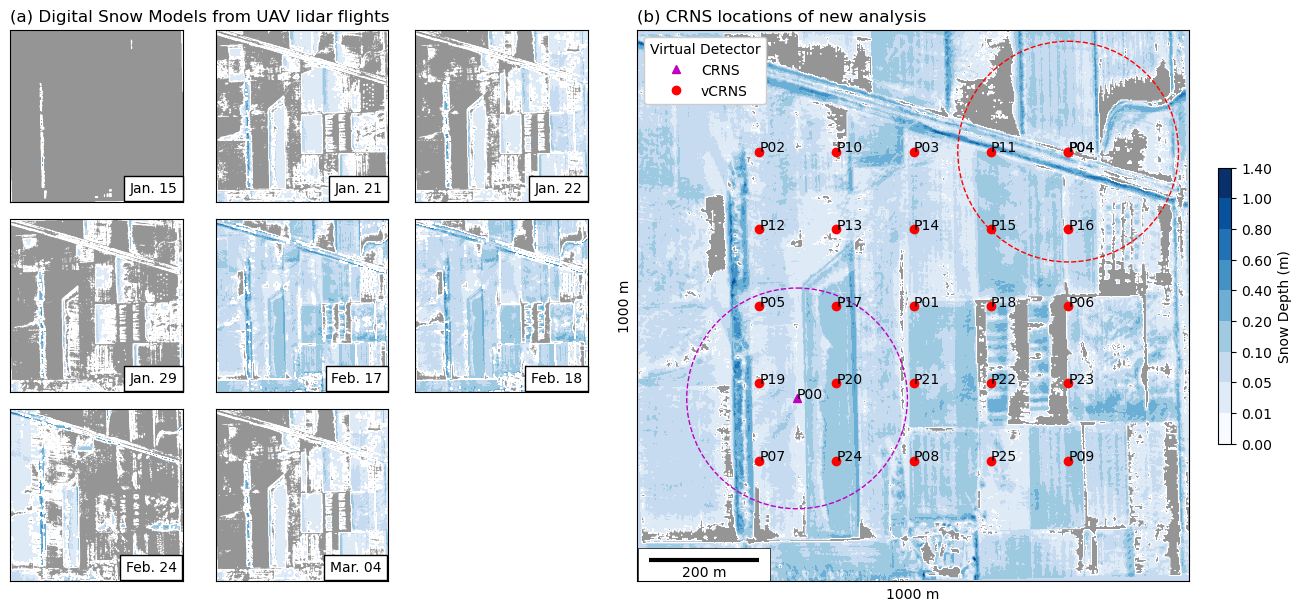

In [65]:
#- Figure 3 Code -----------------
# create boundary norm
bound = np.array([0, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.4])
norm = colors.BoundaryNorm(boundaries=bound, ncolors=256)

fig = plt.figure(figsize=(13,6), constrained_layout=True)
gs = fig.add_gridspec(3,7, width_ratios=[1,1,1,0.05,1,1,1], height_ratios=[1,1,1])

p1 = (249,249)
p2 = (354, 145)

sd_0115_bm = mask_0_sd(sd_0115)
sd_0121_bm = mask_0_sd(sd_0121)
sd_0122_bm = mask_0_sd(sd_0122)
sd_0129_bm = mask_0_sd(sd_0129)
sd_0217_bm = mask_0_sd(sd_0217)
sd_0218_bm = mask_0_sd(sd_0218)
sd_0224_bm = mask_0_sd(sd_0224)
sd_0304_bm = mask_0_sd(sd_0304)

ax7 = fig.add_subplot(gs[0,0])
ax7.imshow(sd_0115_bm.mask, cmap='Greys', vmin=0.5, vmax=1.5)
ax7.imshow(sd_0115_bm.filled(), cmap='Blues', clim=(0.01, 1.4), norm=norm)
ax7.set_title('(a) Digital Snow Models from UAV lidar flights', loc='left')
ax7.tick_params(labelbottom=False, labelleft=False)

ax0 = fig.add_subplot(gs[0,1])
ax0.imshow(sd_0121_bm.mask, cmap='Greys', vmin=0.5, vmax=1.5)
ax0.imshow(sd_0121_bm.filled(), cmap='Blues', clim=(0.01, 1.4), norm=norm)
ax0.tick_params(labelbottom=False, labelleft=False)

ax1 = fig.add_subplot(gs[0,2])
ax1.imshow(sd_0122_bm.mask, cmap='Greys', vmin=0.5, vmax=1.5)
ax1.imshow(sd_0122_bm.filled(), cmap='Blues', clim=(0.01, 1.4), norm=norm)
ax1.tick_params(labelbottom=False, labelleft=False)

ax2 = fig.add_subplot(gs[1,0])
# ax2.imshow(sd_0129, norm=norm, cmap='Blues')
ax2.imshow(sd_0129_bm.mask, cmap='Greys', vmin=0.5, vmax=1.5)
ax2.imshow(sd_0129_bm.filled(), cmap='Blues', clim=(0.01, 1.4), norm=norm)
ax2.tick_params(labelbottom=False, labelleft=False)

ax3 = fig.add_subplot(gs[1,1])
# ax3.imshow(sd_0217, norm=norm, cmap='Blues')
ax3.imshow(sd_0217_bm.mask, cmap='Greys', vmin=0.5, vmax=1.5)
ax3.imshow(sd_0217_bm.filled(), cmap='Blues', clim=(0.01, 1.4), norm=norm)
ax3.tick_params(labelbottom=False, labelleft=False)

ax4 = fig.add_subplot(gs[1,2])
# ax4.imshow(sd_0218, norm=norm, cmap='Blues')
ax4.imshow(sd_0218_bm.mask, cmap='Greys', vmin=0.5, vmax=1.5)
ax4.imshow(sd_0218_bm.filled(), cmap='Blues', clim=(0.01, 1.4), norm=norm)
ax4.tick_params(labelbottom=False, labelleft=False)

ax5 = fig.add_subplot(gs[2,0])
# ax5.imshow(sd_0224, norm=norm, cmap='Blues')
ax5.imshow(sd_0224_bm.mask, cmap='Greys', vmin=0.5, vmax=1.5)
ax5.imshow(sd_0224_bm.filled(), cmap='Blues', clim=(0.01, 1.4), norm=norm)
ax5.tick_params(labelbottom=False, labelleft=False)

ax6 = fig.add_subplot(gs[2,1])
# im4 = ax6.imshow(sd_0304, norm=norm, cmap='Blues')
ax6.imshow(sd_0122_bm.mask, cmap='Greys', vmin=0.5, vmax=1.5)
im4 = ax6.imshow(sd_0122_bm.filled(), cmap='Blues', clim=(0.01, 1.4), norm=norm)
ax6.tick_params(labelbottom=False, labelleft=False)

# ax9 = fig.add_subplot(gs[2,2])
# ax9.axis('off')
# ax9.imshow(sd_zeros, cmap='Greys', vmin=0)
# ax9.tick_params(labelbottom=False, labelleft=False)
# # ax9.axis([0,500,0,500])
# ax9.hlines(y=0,xmin=0,xmax=100, lw=5, color='k')
# ax9.text(x=50, y=20, s='200 m', va='top',
#          ha='center', fontsize=8)


ax7.text(0.69, .12, 'Jan. 15', ha='left', va='top', fontsize=10,
        rotation=0, transform=ax7.transAxes, bbox={
            'ec':'k',
            'fc':'w'
        })
ax0.text(0.69, .12, 'Jan. 21', ha='left', va='top', fontsize=10,
        rotation=0, transform=ax0.transAxes, bbox={
            'ec':'k',
            'fc':'w'
        })
ax1.text(0.69, .12, 'Jan. 22', ha='left', va='top', fontsize=10,
        rotation=0, transform=ax1.transAxes,  bbox={
            'ec':'k',
            'fc':'w'
        })
ax2.text(0.69, .12, 'Jan. 29', ha='left', va='top', fontsize=10,
        rotation=0, transform=ax2.transAxes,  bbox={
            'ec':'k',
            'fc':'w'
        })
ax3.text(0.67, .12, 'Feb. 17', ha='left', va='top', fontsize=10,
        rotation=0, transform=ax3.transAxes,  bbox={
            'ec':'k',
            'fc':'w'
        })
ax4.text(0.67, .12, 'Feb. 18', ha='left', va='top', fontsize=10,
        rotation=0, transform=ax4.transAxes,  bbox={
            'ec':'k',
            'fc':'w'
        })
ax5.text(0.67, .12, 'Feb. 24', ha='left', va='top', fontsize=10,
        rotation=0, transform=ax5.transAxes,  bbox={
            'ec':'k',
            'fc':'w'
        })
ax6.text(0.66, .12, 'Mar. 04', ha='left', va='top', fontsize=10,
        rotation=0, transform=ax6.transAxes,  bbox={
            'ec':'k',
            'fc':'w'
        })

ax0.set_xticks([])
ax0.set_yticks([])
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax4.set_xticks([])
ax4.set_yticks([])
ax5.set_xticks([])
ax5.set_yticks([])
ax6.set_xticks([])
ax6.set_yticks([])
ax7.set_xticks([])
ax7.set_yticks([])
ax9.set_xticks([])
ax9.set_yticks([])

ax8 = fig.add_subplot(gs[0:3,-3:])
ax8.imshow(sd_0217_bm.mask, cmap='Greys', vmin=0.5, vmax=1.5)
img = ax8.imshow(sd_0217_bm.filled(), cmap='Blues', clim=(0.01, 1.4), norm=norm)
# Plotting potential locations for URANOS Runs
p0_x = -211.280 # Detector Pos X [m]
p0_y = -167.261 # Detector Pos Y [m]

p00 = (p0_x,p0_y)
p01 = (   0,    0)
p02 = (-280,  280)
p03 = (   0,  280)
p04 = ( 280,  280)
p05 = (-280,    0)
p06 = ( 280,    0)
p07 = (-280, -280)
p08 =    (0, -280)
p09 = ( 280, -280)
p10 = (-140,  280)
p11 = ( 140,  280)
p12 = (-280,  140)
p13 = (-140,  140)
p14 = (   0,  140)
p15 = ( 140,  140)
p16 = ( 280,  140)
p17 = (-140,    0)
p18 = ( 140,    0)
p19 = (-280, -140)
p20 = (-140, -140)
p21 = (   0, -140)
p22 = ( 140, -140)
p23 = ( 280, -140)
p24 = (-140, -280)
p25 = ( 140, -280)

plotPointFpt(ax8, p00, 'm', 'm^', 'P00', 'CRNS')
# plotPoint(ax8, p00, 'm', 'm^','P00')
plotPoint(ax8, p01, 'r', 'ro','P01')
plotPoint(ax8, p02, 'r', 'ro','P02')
plotPoint(ax8, p03, 'r', 'ro', 'P03')
plotPoint(ax8, p04, 'r', 'ro', 'P04')
plotPointFpt(ax8, p04, 'r', 'ro', 'P04', 'vCRNS')
plotPoint(ax8, p05, 'r', 'ro', 'P05')
plotPoint(ax8, p06, 'r', 'ro', 'P06')
plotPoint(ax8, p07, 'r', 'ro', 'P07')
plotPoint(ax8, p08, 'r', 'ro', 'P08')
plotPoint(ax8, p09, 'r', 'ro', 'P09')
plotPoint(ax8, p10, 'r', 'ro', 'P10')
plotPoint(ax8, p11, 'r', 'ro', 'P11')
plotPoint(ax8, p12, 'r', 'ro', 'P12')
plotPoint(ax8, p13, 'r', 'ro', 'P13')
plotPoint(ax8, p14, 'r', 'ro', 'P14')
# # plotPointFpt(ax8, p14, 'r', 'ro', 'P14', 'runs')
plotPoint(ax8, p15, 'r', 'ro', 'P15')
plotPoint(ax8, p16, 'r', 'ro', 'P16')
plotPoint(ax8, p17, 'r', 'ro', 'P17')
plotPoint(ax8, p18, 'r', 'ro', 'P18')
plotPoint(ax8, p19, 'r', 'ro', 'P19')
plotPoint(ax8, p20, 'r', 'ro', 'P20')
plotPoint(ax8, p21, 'r', 'ro', 'P21')
plotPoint(ax8, p22, 'r', 'ro', 'P22')
plotPoint(ax8, p23, 'r', 'ro', 'P23')
plotPoint(ax8, p24, 'r', 'ro', 'P24')
plotPoint(ax8, p25, 'r', 'ro', 'P25')
plt.colorbar(img, ax=ax8,
                  label='Snow Depth (m)', shrink=0.5)
rect = Rectangle((0,499), 120,-30, 
                  facecolor='white', edgecolor='k', lw=0.5)
ax8.add_patch(rect)
ax8.hlines(y=480,xmin=10,xmax=110, lw=3, color='k')
ax8.text(x=60, y=485, s='200 m', va='top',
         ha='center', fontsize=10)

ax8.legend(title='Virtual Detector', frameon=True, framealpha=1)
ax8.tick_params(labelbottom=False, labelleft=False)
ax8.set_xticks([])
ax8.set_yticks([])
ax8.set_title('(b) CRNS locations of new analysis', loc='left')
ax8.set_xlabel('1000 m')
ax8.set_ylabel('1000 m')
# plt.tight_layout()
# plt.savefig('../figs/to_publish/f03.png', bbox_inches='tight', facecolor='w', dpi=300)
plt.savefig('../figs/to_publish/f03.pdf', bbox_inches='tight', facecolor='w', dpi=300)
plt.show()